# A First Look at a Neural Network in Keras

This notebook is based on the code samples of Chapter 2, Section 1 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff) and hosted on https://github.com/fchollet/deep-learning-with-python-notebooks 

Note that the original text from the book features far more content, in particular further explanations and figures.

In [1]:
import tensorflow as tf
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
from tensorflow import keras
keras.__version__

'2.2.4-tf'

We will now take a look at a first concrete example of a neural network, which makes use of the Python library TensorFlow - Keras to learn to classify 
hand-written digits. Unless you already have experience with Keras or similar libraries, you will not understand everything about this 
first example right away. Don't worry, that is perfectly fine. In the next notebooks, we will 
review each element in our example and explain them in detail. So don't worry if some steps seem arbitrary or look like magic to you! 
We've got to start somewhere.


# MNIST Dataset
* The problem we are trying to solve here is to classify grayscale images of handwritten digits (28 pixels by 28 pixels), into their 10 categories (0 to 9). 
* The dataset we will use is the **MNIST dataset**, a classic dataset in the machine learning community, which has been around for almost as long as the field itself and has been very intensively studied. 
* It's a set of 60,000 training images, plus 10,000 test images, assembled by the National Institute of Standards and Technology (the NIST in MNIST) in the 1980s. 
* You can think of "solving" MNIST as the "Hello World" of deep learning -- it's what you do to verify that your algorithms are working as expected. 
* As you become a machine learning practitioner, you will see MNIST come up over and over again, in scientific papers, blog posts, and so on.

The MNIST dataset comes pre-loaded in Keras, in the form of a set of four Numpy arrays:

In [3]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

`train_images` and `train_labels` form the "training set", the data that the model will learn from. The model will then be tested on the 
"test set", `test_images` and `test_labels`. Our images are encoded as Numpy arrays, and the labels are simply an array of digits, ranging 
from 0 to 9. There is a one-to-one correspondence between the images and the labels.

Let's have a look at the training data:

In [4]:
train_images.shape

(60000, 28, 28)

In [5]:
len(train_labels)

60000

In [6]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

Let's view the first images:

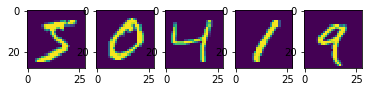

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt
for i in range(5):
    plt.subplot(1,5,1+i)
    plt.imshow(train_images[i])

The `subplot` command from `pyplot` is used to arrange the images one next to the other, and `imshow` displays one image. 

Let's have a look at the test data:

In [8]:
test_images.shape

(10000, 28, 28)

In [9]:
len(test_labels)

10000

In [10]:
test_labels

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

Our workflow will be as follow: 
1. First we design a neural network. 
2. Then we will present our neural network with the training data, `train_images` and `train_labels`. 
3. The network will then learn to associate images and labels. 
4. Finally, we will ask the network to produce predictions for `test_images`, and we will verify if these predictions match the labels from `test_labels`.



Let's build a simple **feedforward** network:

In [11]:
from tensorflow.keras import models
from tensorflow.keras import layers

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
network.add(layers.Dense(10, activation='softmax'))

* The above code specifies a sequence of two dense layers. This means that every node from one layer is connected to every node of the next layer.
* The first layer has 512 nodes, and the activation function is *relu*. This is a very common activation function for the middle layers of a model. The first layer must specify the number of input nodes. In this case, there are 28 * 28 = 784 nodes.
* The final layer has 10 nodes, one per final label. The activation function is *softmax*. This activation functions is very common for multi-class classification.


The core building block of neural networks is the **layer**, a data-processing module which you can conceive as a "filter" for data. Some 
data comes in, and comes out in a more useful form. Precisely, layers extract _representations_ out of the data fed into them -- hopefully 
representations that are more meaningful for the problem at hand. Most of deep learning really consists of chaining together simple layers 
which will implement a form of progressive "data distillation". A deep learning model is like a sieve for data processing, made of a 
succession of increasingly refined data filters -- the "layers".

Here our network consists of a sequence of two `Dense` layers, which are densely-connected (also called "fully-connected") neural layers. 
The second (and last) layer is a 10-way "softmax" layer, which means it will return an array of 10 probability scores (summing to 1). Each 
score will be the probability that the current digit image belongs to one of our 10 digit classes.


To make our network ready for training, we need to pick three more things, as part of the "compilation" step:

1. A **loss function**: this is how the network will be able to measure how good a job it is doing on its training data, and thus how it will be 
able to steer itself in the right direction. We will use *categorical crossentropy*, which is a common loss function for multi-class classification.
2. An **optimizer**: this is the mechanism through which the network will update itself based on the data it sees and its loss function.
3. **Metrics to monitor during training and testing**. Here we will only care about accuracy (the fraction of the images that were correctly 
classified).


In [12]:
network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

The `summary` method helps us understand the structure of the model.

In [13]:
network.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


As we see, the model is composed of two layers. The last layer has one node per final label.

There are 407,050 parameters. Can you work out why? *(hint: note that all nodes of each layer are connected to the nodes of the next layer, and there is an additional hidden node in each layer that represents the bias)*


Before training, we will preprocess our data by reshaping it into the shape that the network expects, and scaling it so that all values are in 
the `[0, 1]` interval. Previously, our training images for instance were stored in an array of shape `(60000, 28, 28)` of type `uint8` with 
values in the `[0, 255]` interval. We transform it into a `float32` array of shape `(60000, 28 * 28)` with values between 0 and 1.

In [14]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

We also need to categorically encode the labels using **one-hot encoding**.

In [15]:
from tensorflow.keras.utils import to_categorical

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [16]:
train_labels.shape

(60000, 10)

In [17]:
train_labels[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

We are now ready to train our network, which in Keras is done via a call to the `fit` method of the network: 
we "fit" the model to its training data.

In [18]:
network.fit(train_images, train_labels, epochs=5, batch_size=128)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 3s 55us/sample - loss: 0.2531 - accuracy: 0.9261
Epoch 2/5
60000/60000 [==============================] - 1s 16us/sample - loss: 0.1043 - accuracy: 0.9700
Epoch 3/5
60000/60000 [==============================] - 1s 15us/sample - loss: 0.0684 - accuracy: 0.9796
Epoch 4/5
60000/60000 [==============================] - 1s 16us/sample - loss: 0.0499 - accuracy: 0.9850
Epoch 5/5
60000/60000 [==============================] - 1s 16us/sample - loss: 0.0374 - accuracy: 0.9890


Two quantities are being displayed during training: the "loss" of the network over the training data, and the accuracy of the network over 
the training data.

We quickly reach an accuracy of 0.989 (i.e. 98.9%) on the training data. 

Now let's check that our model performs well on the test set too:

In [19]:
test_loss, test_acc = network.evaluate(test_images, test_labels)

10000/10000 [==============================] - 0s 47us/sample - loss: 0.0686 - accuracy: 0.9780


In [20]:
print('test_acc:', test_acc)

test_acc: 0.978



Our test set accuracy turns out to be 97.8% -- that's quite a bit lower than the training set accuracy. 
This gap between training accuracy and test accuracy is an example of **overfitting**, 
the fact that machine learning models tend to perform worse on new data than on their training data. 


This concludes our very first example -- you just saw how we could build and a train a neural network to classify handwritten digits, in 
less than 20 lines of Python code. In the next notebook, we will go in detail over every moving piece we just previewed, and clarify what is really 
going on behind the scenes. You will learn about "tensors", the data-storing objects going into the network, about tensor operations, which 
layers are made of, and about gradient descent, which allows our network to learn from its training examples.